<a href="https://colab.research.google.com/github/bhindia/Project_Results/blob/master/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [2]:
pip install sgt # installing Sequence Graph Transform (sgt) package

In [3]:
pip install pandarallel # installing pandarallel package for multi-processing

  Created wheel for pandarallel: filename=pandarallel-1.5.1-cp36-none-any.whl size=17126 sha256=b78f92d309e157cbe7f00019aaff3cb379abfaa6befe504ef8b76ba2ff6621ea
  Stored in directory: /root/.cache/pip/wheels/6f/c8/e5/d43fa63105ce1dd22f4df51bc2edfefd54d92ce64f25326314
Successfully built pandarallel


In [4]:
import sgt                  # import sgt package
from sgt import SGT         # import SGT from sgt package

In [5]:
import numpy as np                            # import numpy as np
import pandas as pd                           # import pandas as pd
import time                                   # import time
from pandarallel import pandarallel           # required library for multiprocessing
from sklearn.decomposition import PCA         # import PCA from sklearn
from sklearn.metrics import calinski_harabasz_score # import calinski_harabasz_score from sklearn
from sklearn.metrics import silhouette_score        # import silhouette_score from sklearn
import seaborn as sns                         # import seaborn as sns
import matplotlib.pyplot as plt               # import matplotlib.pyplot as plt
#%matplotlib inline
from sklearn.cluster import KMeans            # import KMeans from sklearn
np.random.seed(7)                             # fix random seed for reproducibility



In [6]:
train = pd.read_table('/gdrive/My Drive/Capstone/Cluster-Data.tsv',sep='\t',header=0,skipinitialspace=True) # Reading the file

In [7]:
train= train[['aminoAcid','Subject','Year','Day','Status','countTemplates']] # Selecting variables required for analysis


In [8]:
train.count() # Count of different variables

aminoAcid         278148
Subject           278148
Year              278148
Day               278148
Status            278148
countTemplates    278148
dtype: int64

In [9]:
seq = train['aminoAcid'].map(list)    # changing each aminoacid to a list
seq = seq.to_dict()                   # Changing to a dictionary
seq = list(map(list, seq.items()))    # changing into a list contains multiple lists with ids and sequences
corpus = pd.DataFrame(seq, columns= ['id','sequence']) # converts seq list into a pandas dataframe with columns id and sequence
corpus                                # printing corpus

,id,sequence
0,0,"[C, T, S, S, H, H, A, L, G, R, S, Y, N, E, Q, ..."
1,1,"[C, A, I, G, D, R, R, S, L, N, T, E, A, F, F]"
2,2,"[C, A, S, A, W, A, L, D, T, S, Y, E, Q, Y, F]"
3,3,"[C, A, S, G, Q, T, A, S, G, A, N, V, L, T, F]"
4,4,"[C, A, S, G, Q, T, R, G, E, T, Q, Y, F]"
...,...,...
278143,278143,"[C, A, S, S, F, T, N, M, G, T, S, G, G, T, L, ..."
278144,278144,"[C, A, S, S, L, G, T, R, T, H, T, H, K, S, Y, ..."
278145,278145,"[C, A, S, S, L, V, F, S, S, F, G, I, G, G, T, ..."
278146,278146,"[C, A, S, S, N, R, G, T, G, L, F, G, A, G, A, ..."


In [10]:
# alphabets            The set of alphabets that make up all the sequences in the dataset. 
#                      If not passed, the alphabet set is automatically computed as the unique set of elements that make all the sequences. 
#                      A list or 1d-array of the set of elements that make up the sequences. For example, np.array(["A", "B", "C"].

# lengthsensitive      Default false. This is set to true if the embedding 
#                      should have the information of the length of the sequence.
#                      If set to false then the embedding of two sequences with
#                      similar pattern but different lengths will be the same.
#                      lengthsensitive = false is similar to length-normalization.


#  kappa              Tuning parameter, kappa > 0, to change the extraction of 
#                     long-term dependency. Higher the value the lesser
#                     the long-term dependency captured in the embedding.
#                     Typical values for kappa are 1, 5, 10.

# flatten              Default True. If True the SGT embedding is flattened and returned as
#                     a vector. Otherwise, it is returned as a matrix with the row and col
#                     names same as the alphabets. The matrix form is used for            
#                     interpretation purposes. Especially, to understand how the alphabets
#                     are "related". Otherwise, for applying machine learning or deep
#                     learning algorithms, the embedding vectors are required.

# mode               Choices in {'default', 'multiprocessing'}. Note: 'multiprocessing' 
#                    mode requires pandas==1.0.3 + and pandarallel libraries.
    
#processors          Used if mode is 'multiprocessing'. By default, the 
#                    number of processors used in multiprocessing is number of available (1)
%%time
alphabets = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 
             'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 
             'W', 'Y']  
sgt_ = SGT(alphabets=alphabets, lengthsensitive=True, kappa=5, flatten=True,mode='multiprocessing',processors=10)

#                   Extract SGT embeddings for all sequences in a corpus. It finds
#                   the alphabets encompassing all the sequences in the corpus, if not inputted.
#                   Input: corpus - A list of sequences. Each sequence is a list of alphabets.
#                   Output: sgt embedding of all sequences in the corpus.

sgtembedding_df = sgt_.fit_transform(corpus)    

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
CPU times: user 1.19 s, sys: 1.4 s, total: 2.59 s
Wall time: 17min 6s


In [11]:
sgtembedding_df   # printing sgt embeddings

,id,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)","(A, M)","(A, N)","(A, P)","(A, Q)","(A, R)","(A, S)","(A, T)","(A, V)","(A, W)","(A, Y)","(C, A)","(C, C)","(C, D)","(C, E)","(C, F)","(C, G)","(C, H)","(C, I)","(C, K)","(C, L)","(C, M)","(C, N)","(C, P)","(C, Q)","(C, R)","(C, S)","(C, T)","(C, V)","(C, W)",...,"(W, A)","(W, C)","(W, D)","(W, E)","(W, F)","(W, G)","(W, H)","(W, I)","(W, K)","(W, L)","(W, M)","(W, N)","(W, P)","(W, Q)","(W, R)","(W, S)","(W, T)","(W, V)","(W, W)","(W, Y)","(Y, A)","(Y, C)","(Y, D)","(Y, E)","(Y, F)","(Y, G)","(Y, H)","(Y, I)","(Y, K)","(Y, L)","(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
0,0.0,0.000000,0.0,0.000000e+00,1.607046e-03,1.895906e-04,0.238507,0.000000,0.000000,0.00000,0.648329,0.0000,0.004368,0.0,5.911993e-04,0.087742,0.032278,0.000000,0.000000,0.000000,1.187456e-02,0.004368,0.0,0.000000e+00,3.983470e-06,4.699480e-07,0.000591,0.028138,0.00000,0.000000,0.001607,0.000000,1.082819e-05,0.0,1.465437e-06,0.000217,0.191717,6.483288e-01,0.000000e+00,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.238507,0.028138,0.0,0.0,0.0,0.0,0.0,0.0,0.648329,0.0,0.087742,0.0,0.0,0.000000,0.0,0.0,0.000000
1,1.0,0.000029,0.0,8.557262e-02,7.803212e-05,4.798385e-01,0.232610,0.000000,0.632301,0.00000,0.001567,0.0000,0.000577,0.0,0.000000e+00,0.027442,0.004260,0.000212,0.000000,0.000000,0.000000e+00,0.550450,0.0,3.148041e-02,2.870641e-05,3.386626e-06,0.085573,0.000000,0.23261,0.000000,0.000577,0.000000,2.121133e-04,0.0,0.000000e+00,0.010095,0.001567,7.803212e-05,0.000000e+00,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2,2.0,0.214493,0.0,1.867278e-01,3.420039e-03,1.702737e-04,0.000000,0.000000,0.000000,0.00000,0.507579,0.0000,0.000000,0.0,1.258162e-03,0.000000,0.479194,0.068693,0.000000,0.550455,8.093187e-03,0.507579,0.0,1.567317e-03,2.870641e-05,1.429208e-06,0.000000,0.000000,0.00000,0.000000,0.004260,0.000000,0.000000e+00,0.0,1.056050e-05,0.000000,0.202499,5.765837e-04,0.000000e+00,0.03148,...,0.632301,0.0,0.085573,0.001567,0.000078,0.0,0.0,0.0,0.0,0.23261,0.0,0.0,0.0,0.000577,0.0,0.011581,0.03148,0.0,0.0,0.003709,0.0,0.0,0.000000,0.632301,0.550450,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.232610,0.0,0.0,0.000000,0.0,0.0,0.085573
3,3.0,0.068693,0.0,0.000000e+00,0.000000e+00,9.296546e-03,0.214492,0.000000,0.000000,0.00000,0.068693,0.0000,0.507574,0.0,8.557262e-02,0.000000,0.583050,0.027405,0.186726,0.000000,0.000000e+00,0.507574,0.0,0.000000e+00,0.000000e+00,1.429208e-06,0.074495,0.000000,0.00000,0.000000,0.000011,0.000000,7.803212e-05,0.0,3.148041e-02,0.000000,0.202499,1.008184e-02,2.870641e-05,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4,4.0,0.000000,0.0,0.000000e+00,1.523096e-03,2.789648e-05,0.196786,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.0,7.239344e-02,0.011254,0.614461,0.026632,0.000000,0.000000,7.583049e-05,0.614461,0.0,0.000000e+00,5.603157e-04,1.026254e-05,0.072393,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.0,2.663206e-02,0.004140,0.226047,9.797387e-03,0.000000e+00,0.00000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.614461,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

In [12]:
sgtembedding_df = sgtembedding_df.set_index('id') # setting id column as the dataframe index
sgtembedding_df

,"(A, A)","(A, C)","(A, D)","(A, E)","(A, F)","(A, G)","(A, H)","(A, I)","(A, K)","(A, L)","(A, M)","(A, N)","(A, P)","(A, Q)","(A, R)","(A, S)","(A, T)","(A, V)","(A, W)","(A, Y)","(C, A)","(C, C)","(C, D)","(C, E)","(C, F)","(C, G)","(C, H)","(C, I)","(C, K)","(C, L)","(C, M)","(C, N)","(C, P)","(C, Q)","(C, R)","(C, S)","(C, T)","(C, V)","(C, W)","(C, Y)",...,"(W, A)","(W, C)","(W, D)","(W, E)","(W, F)","(W, G)","(W, H)","(W, I)","(W, K)","(W, L)","(W, M)","(W, N)","(W, P)","(W, Q)","(W, R)","(W, S)","(W, T)","(W, V)","(W, W)","(W, Y)","(Y, A)","(Y, C)","(Y, D)","(Y, E)","(Y, F)","(Y, G)","(Y, H)","(Y, I)","(Y, K)","(Y, L)","(Y, M)","(Y, N)","(Y, P)","(Y, Q)","(Y, R)","(Y, S)","(Y, T)","(Y, V)","(Y, W)","(Y, Y)"
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.0,0.000000,0.0,0.000000e+00,1.607046e-03,1.895906e-04,0.238507,0.000000,0.000000,0.00000,0.648329,0.0000,0.004368,0.0,5.911993e-04,0.087742,0.032278,0.000000,0.000000,0.000000,1.187456e-02,0.004368,0.0,0.000000e+00,3.983470e-06,4.699480e-07,0.000591,0.028138,0.00000,0.000000,0.001607,0.000000,1.082819e-05,0.0,1.465437e-06,0.000217,0.191717,6.483288e-01,0.000000e+00,0.00000,2.943408e-05,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.238507,0.028138,0.0,0.0,0.0,0.0,0.0,0.0,0.648329,0.0,0.087742,0.0,0.0,0.000000,0.0,0.0,0.000000
1.0,0.000029,0.0,8.557262e-02,7.803212e-05,4.798385e-01,0.232610,0.000000,0.632301,0.00000,0.001567,0.0000,0.000577,0.0,0.000000e+00,0.027442,0.004260,0.000212,0.000000,0.000000,0.000000e+00,0.550450,0.0,3.148041e-02,2.870641e-05,3.386626e-06,0.085573,0.000000,0.23261,0.000000,0.000577,0.000000,2.121133e-04,0.0,0.000000e+00,0.010095,0.001567,7.803212e-05,0.000000e+00,0.00000,0.000000e+00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
2.0,0.214493,0.0,1.867278e-01,3.420039e-03,1.702737e-04,0.000000,0.000000,0.000000,0.00000,0.507579,0.0000,0.000000,0.0,1.258162e-03,0.000000,0.479194,0.068693,0.000000,0.550455,8.093187e-03,0.507579,0.0,1.567317e-03,2.870641e-05,1.429208e-06,0.000000,0.000000,0.00000,0.000000,0.004260,0.000000,0.000000e+00,0.0,1.056050e-05,0.000000,0.202499,5.765837e-04,0.000000e+00,0.03148,6.793091e-05,...,0.632301,0.0,0.085573,0.001567,0.000078,0.0,0.0,0.0,0.0,0.23261,0.0,0.0,0.0,0.000577,0.0,0.011581,0.03148,0.0,0.0,0.003709,0.0,0.0,0.000000,0.632301,0.550450,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.232610,0.0,0.0,0.000000,0.0,0.0,0.085573
3.0,0.068693,0.0,0.000000e+00,0.000000e+00,9.296546e-03,0.214492,0.000000,0.000000,0.00000,0.068693,0.0000,0.507574,0.0,8.557262e-02,0.000000,0.583050,0.027405,0.186726,0.000000,0.000000e+00,0.507574,0.0,0.000000e+00,0.000000e+00,1.429208e-06,0.074495,0.000000,0.00000,0.000000,0.000011,0.000000,7.803212e-05,0.0,3.148041e-02,0.000000,0.202499,1.008184e-02,2.870641e-05,0.00000,0.000000e+00,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
4.0,0.000000,0.0,0.000000e+00,1.523096e-03,2.789648e-05,0.196786,0.000000,0.000000,0.00000,0.000000,0.0000,0.000000,0.0,7.239344e-02,0.011254,0.614461,0.026632,0.000000,0.000000,7.583049e-05,0.614461,0.0,0.000000e+00,5.603157e-04,1.026254e-05,0.072393,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000e+00,0.0,2.663206e-02,0.004140,0.226047,9.797387e-03,0.000000e+00,0.00000,2.789648e-05,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.614461,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,..

In [13]:
pca = PCA(n_components=40)                   # we choose 40 components   
pca.fit(sgtembedding_df)                     # fit the model with the selected number of components. In our case 60.
X = pca.transform(sgtembedding_df)            
print(np.sum(pca.explained_variance_ratio_)) # print the explained variance ratio
PCA_components = pd.DataFrame(X)             # changing to pandas dataframe


0.6549320487193069


In [14]:
PCA_components                               # printing PCA components                 

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39
0,0.155610,-0.454077,-0.396853,0.136314,0.855942,0.098955,0.007132,0.028077,0.194757,0.207188,0.624762,0.068302,0.317746,-0.229736,0.093868,0.257851,0.193887,-0.352452,-0.124630,-0.231406,0.366170,0.311859,0.263915,-0.288894,-0.193772,0.208707,0.159977,-0.078539,-0.294661,0.188265,0.236145,0.211791,0.155199,0.090208,0.190447,0.162620,0.059179,0.110232,0.376329,-0.056351
1,0.770885,-0.523061,0.043549,0.333174,-0.180370,0.773477,-0.129189,0.270990,0.059274,0.024925,0.270026,-0.274246,-0.060864,-0.134021,0.419375,-0.092162,-0.006468,0.047551,0.310029,-0.020295,-0.007410,0.356587,-0.105946,-0.231192,0.106404,-0.138373,0.051273,0.096797,0.217019,0.220888,-0.189504,0.005243,0.154462,-0.201284,0.307324,0.401802,-0.050362,-0.129906,-0.364512,-0.033953
2,-0.861787,-0.323503,-0.233328,0.343649,0.354447,0.100332,-0.009764,0.160180,0.014257,-0.181055,0.378213,0.075216,-0.247226,0.173415,0.176315,-0.346948,0.147221,0.143380,0.081760,-0.083137,-0.029224,0.082178,-0.098405,-0.105547,0.046645,-0.063096,0.040050,-0.130458,-0.224292,-0.020686,-0.100428,0.349037,0.144614,-0.007449,-0.153378,-0.009310,-0.287020,0.174930,-0.001473,-0.045288
3,0.269690,0.217857,0.310558,0.214504,-0.096517,-0.074518,0.279923,-0.182957,0.470934,0.103582,-0.044758,0.187845,0.128593,1.164314,0.276486,0.147112,0.078295,-0.065259,-0.003974,0.211626,0.289275,0.139778,-0.299174,0.150478,0.039413,-0.347709,0.182945,-0.050237,0.177579,-0.279385,-0.152375,0.181034,0.178837,-0.184083,0.046814,0.056400,0.229185,0.006528,0.125227,-0.335025
4,-0.636760,-0.216708,-0.027662,0.158750,-0.361162,-0.233365,-0.069150,-0.246931,-0.289458,-0.008297,-0.478595,-0.041516,0.094000,-0.015160,0.313651,0.521590,0.044725,-0.106548,0.007817,-0.087551,0.158042,0.248414,0.170229,0.117240,0.230013,-0.204186,0.032945,-0.134883,0.346031,-0.152406,-0.008914,0.061475,-0.155423,-0.214099,-0.061075,-0.050055,0.091033,0.030752,0.020900,-0.196012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278143,-0.745403,-0.152475,0.111521,-0.130234,-0.792631,-0.181854,-0.077257,-0.165671,-0.136614,-0.315693,0.574183,0.280083,0.433240,0.042713,0.086967,-0.251127,0.063456,0.064592,-0.107167,-0.107505,0.062282,-0.101442,-0.095144,-0.062212,0.042263,-0.172761,0.208912,-0.104478,-0.219849,-0.314055,0.026028,-0.010627,-0.142705,0.195425,0.016664,-0.182660,0.102740,-0.046430,-0.037982,0.006297
278144,0.169168,-0.482188,-0.308241,-0.456341,0.663029,0.105380,-0.013107,-0.037204,-0.014220,0.068689,0.813473,-0.077506,0.411186,-0.223416,0.121140,0.351579,0.382644,-0.147488,-0.219311,0.124401,0.285296,0.117543,0.188464,0.051391,-0.114218,-0.138733,-0.060847,0.053847,-0.205745,0.211477,0.107707,0.244084,0.006794,-0.140272,0.250306,-0.048527,0.107898,0.110096,0.377514,-0.161011
278145,-0.759167,-0.135769,0.097265,-0.296309,-0.781250,-0.130075,-0.283077,-0.066801,0.177359,-0.009364,0.437568,0.102941,0.308366,-0.261421,0.039487,-0.373072,-0.127558,-0.044442,-0.111331,0.194086,-0.071234,-0.225974,0.010721,-0.018477,-0.052457,-0.281173,-0.232160,-0.148690,-0.214483,-0.008106,-0.139040,0.205224,-0.066384,-0.056414,0.214807,0.097176,0.168769,-0.041049,-0.121863,0.154479
278146,0.382005,0.136382,0.409971,-0.163424,-0.170340,-0.436054,0.300551,-0.163556,0.225367,0.097739,0.100728,-0.484589,0.219667,1.067711,-0.252717,0.165098,-0.054330,-0.137359,-0.198635,0.307723,0.066652,-0.061208,-0.108641,-0.119803,0.479785,-0.287155,0.148498,0.349914,-0.069281,-0.254119,-0.132204,0.071693,0.247590,0.071129,0.144914,0.014467,0.234673,0.229864,0.153740,0.040461


Text(0, 0.5, 'variance %')

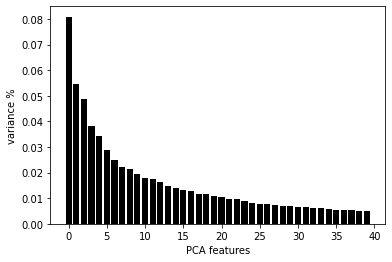

In [15]:
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')

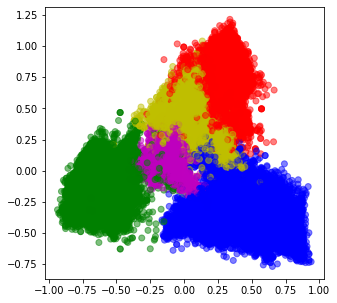

In [16]:
# K-Means Parameters are listed below.

#  init: 'k-means++' : selects initial cluster centers for k-mean clustering in a smart way to speed up convergence. See section Notes in k_init for more details.
#  n_clusters: The number of clusters to form as well as the number of centroids to generate.
#  n_init:  Number of times the k-means algorithm will be run with different centroid seeds, the final results will be the best output of n_init consecutive runs in terms of inertia.
#  max_iter: Maximum number of iterations of the k-means algorithm for a single run.

kmeans = KMeans(n_clusters=5, max_iter =300,init='k-means++', n_init=10)  # Running kmeans algorithm
kmeans.fit(PCA_components)                # Compute k-means clustering using PCA_components
labels = kmeans.predict(PCA_components)   # Predict the closest cluster each sample in PCA_components belongs to.
centroids = kmeans.cluster_centers_       # Getting the cluster centers from the model
fig = plt.figure(figsize=(5, 5))
#colors = list("bgrcmyk")
colmap = {1: 'r', 2: 'g', 3: 'b', 4: 'y', 5:'m', 6:'c', 7:'k', 8:'#c1a4a9', 9:'#38293c', 10:'#f2ebed'}
colors = list(map(lambda x: colmap[x+1], labels))
plt.scatter(PCA_components[0], PCA_components[1], color=colors, alpha=0.5, edgecolor=colors) # plotting scatterplot using the first two PC components.


In [17]:
chscore = calinski_harabasz_score(PCA_components,labels) # Calculating CH-Score
chscore                                                  # printing CH-Score

28735.68945220651

In [32]:
silh_score = silhouette_score(PCA_components,labels)    # Calculating Silhouette score
silh_score                                              # printing Silhouette Score

0.1824559911795455

In [23]:
# create a new dataframe with original features and add the pca scores and assigned clusters.
test_pca_kmeans = pd.concat([train.reset_index(drop=True),PCA_components[1]], axis=1)
test_pca_kmeans['Cluster'] = kmeans.labels_  # Assigning cluster labels to 'Cluster' variable

In [24]:
df= test_pca_kmeans[['aminoAcid','Subject','Year','Day','Status','countTemplates','Cluster']] # Selecting variables required
df.to_csv('/gdrive/My Drive/Capstone/Cluster-Results.csv') # Save into a .csv file

In [25]:
df  # Printing dataframe

,aminoAcid,Subject,Year,Day,Status,countTemplates,Cluster
0,CTSSHHALGRSYNEQFF,Sbj_05,2016,day0,active,1,2
1,CAIGDRRSLNTEAFF,Sbj_05,2016,day0,active,1,2
2,CASAWALDTSYEQYF,Sbj_05,2016,day0,active,1,1
3,CASGQTASGANVLTF,Sbj_05,2016,day0,active,1,3
4,CASGQTRGETQYF,Sbj_05,2016,day0,active,1,1
...,...,...,...,...,...,...,...
278143,CASSFTNMGTSGGTLSTDTQYF,Sbj_14,2017,day7,resting,1,1
278144,CASSLGTRTHTHKSYNEQFF,Sbj_14,2017,day7,resting,1,2
278145,CASSLVFSSFGIGGTDTQYF,Sbj_14,2017,day7,resting,1,1
278146,CASSNRGTGLFGAGANVLTF,Sbj_14,2017,day7,resting,1,3


In [26]:
df1 = df.loc[df['Cluster']== 0,:]     # Cluster labeled '0'
df2 = df.loc[df['Cluster']== 1,:]     # Cluster labeled '1'
df3 = df.loc[df['Cluster']== 2,:]     # Cluster labeled '2'
df4 = df.loc[df['Cluster']== 3,:]     # Cluster labeled '3'
df5 = df.loc[df['Cluster']== 4,:]     # Cluster labeled '4'

In [27]:
df1  # Printing Cluster1


,aminoAcid,Subject,Year,Day,Status,countTemplates,Cluster
16,CASRGDNSPLHF,Sbj_05,2016,day0,active,2,0
18,CASSDPRAGNQPQHF,Sbj_05,2016,day0,active,1,0
22,CASSEGSLGISPLHF,Sbj_05,2016,day0,active,1,0
24,CASSELGAAAQPQHF,Sbj_05,2016,day0,active,2,0
31,CASSLGSSPLHF,Sbj_05,2016,day0,active,1,0
...,...,...,...,...,...,...,...
278108,CAWSVGDSNQPQHF,Sbj_14,2017,day7,resting,1,0
278109,CAWSVGSSNQPQHF,Sbj_14,2017,day7,resting,1,0
278111,CAWSVKSNQPQHF,Sbj_14,2017,day7,resting,1,0
278121,CAWSVRSSSYNSPLHF,Sbj_14,2017,day7,resting,1,0


In [28]:
df2 # Printing Cluster2

,aminoAcid,Subject,Year,Day,Status,countTemplates,Cluster
2,CASAWALDTSYEQYF,Sbj_05,2016,day0,active,1,1
4,CASGQTRGETQYF,Sbj_05,2016,day0,active,1,1
5,CASGRDIKETQYF,Sbj_05,2016,day0,active,3,1
6,CASKEGSGTDTQYF,Sbj_05,2016,day0,active,1,1
7,CASKESGTDTQYF,Sbj_05,2016,day0,active,1,1
...,...,...,...,...,...,...,...
278137,CAWTQGSSAIYF,Sbj_14,2017,day7,resting,1,1
278141,CAYKPGQGSVSYEQYF,Sbj_14,2017,day7,resting,1,1
278143,CASSFTNMGTSGGTLSTDTQYF,Sbj_14,2017,day7,resting,1,1
278145,CASSLVFSSFGIGGTDTQYF,Sbj_14,2017,day7,resting,1,1


In [29]:
df3 # Printing Cluster3

,aminoAcid,Subject,Year,Day,Status,countTemplates,Cluster
0,CTSSHHALGRSYNEQFF,Sbj_05,2016,day0,active,1,2
1,CAIGDRRSLNTEAFF,Sbj_05,2016,day0,active,1,2
8,CASKFEIFNEKLFF,Sbj_05,2016,day0,active,1,2
13,CASRDRGAGELFF,Sbj_05,2016,day0,active,1,2
14,CASRDRGGNEKLFF,Sbj_05,2016,day0,active,1,2
...,...,...,...,...,...,...,...
278133,CAWTKDAGELFF,Sbj_14,2017,day7,resting,1,2
278138,CAWTTGANEKLFF,Sbj_14,2017,day7,resting,1,2
278139,CAWTTGGNEAFF,Sbj_14,2017,day7,resting,1,2
278140,CAWWRAQGRTEAFF,Sbj_14,2017,day7,resting,1,2


In [30]:
df4    # Printing Cluster4

,aminoAcid,Subject,Year,Day,Status,countTemplates,Cluster
3,CASGQTASGANVLTF,Sbj_05,2016,day0,active,1,3
11,CASNGPSGANVLTF,Sbj_05,2016,day0,active,1,3
12,CASRAGGTNYGYTF,Sbj_05,2016,day0,active,1,3
21,CASSEEGGRYNYGYTF,Sbj_05,2016,day0,active,1,3
28,CASSGDTGANVLTF,Sbj_05,2016,day0,active,2,3
...,...,...,...,...,...,...,...
278125,CAWSVTGGSSGANVLTF,Sbj_14,2017,day7,resting,1,3
278129,CAWSYLQENSYGYTF,Sbj_14,2017,day7,resting,1,3
278131,CAWTGDTLVRYGYTF,Sbj_14,2017,day7,resting,1,3
278135,CAWTKTGAGANVLTF,Sbj_14,2017,day7,resting,1,3


In [31]:
df5    # Printing Cluster5

,aminoAcid,Subject,Year,Day,Status,countTemplates,Cluster
70,CASSQGAAGNTIYF,Sbj_05,2016,day0,active,2,4
84,CASSTRQGSSGNTIYF,Sbj_05,2016,day0,active,1,4
112,CASSQEGWQVSGNTIYF,Sbj_05,2016,day0,active,1,4
113,CASSQGVGDSGNTIYF,Sbj_05,2016,day0,active,1,4
138,CASSFQGQPGNTIYF,Sbj_05,2016,day0,active,1,4
...,...,...,...,...,...,...,...
278091,CAWSPGWAGNTIYF,Sbj_14,2017,day7,resting,1,4
278094,CAWSRDITGNTIYF,Sbj_14,2017,day7,resting,1,4
278112,CAWSVLAPGGYGNTIYF,Sbj_14,2017,day7,resting,1,4
278122,CAWSVSSFGNTIYF,Sbj_14,2017,day7,resting,1,4
